Class Information: Yonsei University CSI4121 2021-1 \
Student Information: Dongha Kim \
　　

This report is about MLP model implement of MNIST dataset. \
In this report, there are code explanation of each implement, \
and evaluation of model performance.

###### this report's code requires python version upper than 3.7!

## Configuration

You can config script's options by modifying options below.

In [1]:
#
# Configurations
#

# Model Configuration
BATCH_SIZE = 64
TEST_BATCH_SIZE = 1000
LEARNING_RATE = 1e0
LEARNING_RATE_STEP_GAMMA = 7e-1
USE_CUDA = False

# File I/O Configuration
BASE_DIR = './'
DATASET_FOLDER = 'data'

# Learning Verbosity Configuration
VERBOSE = False

This code below is internal codes. \
In this portion, frameworks are loaded and MNIST datasets are downloaded.

In [2]:
#
# Imports and internal prepares
#

# Framework import
import torch
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils.data
import torchvision

# Utility import
import sys
import os
import collections
import functools
import platform
import matplotlib.pyplot as plt

# Download and load datasets
_DATASET_DIR = os.path.join(BASE_DIR, DATASET_FOLDER)
_t = torchvision.transforms.ToTensor()
_TRAIN_DATA = torchvision.datasets.MNIST(
    root=_DATASET_DIR, train=True, download=True, transform=_t)
_TEST_DATA = torchvision.datasets.MNIST(
    root=_DATASET_DIR, train=False, download=True, transform=_t)
del _t

# Prepare cuda-related variables
_USE_CUDA = USE_CUDA and torch.cuda.is_available()
_DEVICE = torch.device("cuda" if _USE_CUDA else "cpu")
_EXTRA_KWARGS = {'pin_memory': True, 'num_workers': 1} if _USE_CUDA else {}

# Environment check
print(
    "OS version: \t\t{0}\nPython version:\t\t{1}\nTorch version:\t\t{2}"
        .format(platform.platform(), sys.version, torch.__version__)
)


OS version: 		Windows-10-10.0.19041-SP0
Python version:		3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Torch version:		1.8.1


# Implements

## Implement of MLP Model
I implemented MLP model with five linear perceptron layers, \
relu functions for activation, and cross entropy error for loss function. \
(loss function, implement is not in model class, but in train function impl.) \
\
I added two methods that can save and load weight parameters to or from .pt file.

In [3]:
#
# Model implements
#

class Net(torch.nn.Module):
    """
Implement of MLP Model.

I implemented MLP model with five linear perceptron layers,
relu functions for activation, and cross entropy error for loss function.

I added two methods that can save and load weight parameters to or from .pt file.
"""

    # Class method that can initialize directly from .pt filename
    @classmethod
    def initialize_from_pt(cls, filename):
        self = cls()
        self.load_from_pt(filename)
        return self

    # Method that saves weight parameters into .pt file
    def save_to_pt(self, filename):
        torch.save(self.state_dict(), filename)

    # Method that loads weight parameters from .pt file
    def load_from_pt(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()

    # Constructor
    # Register layers in constructor
    def __init__(self, pt_filename=None):
        super(Net, self).__init__()
        # I used ordered dict for convenience in forward method
        self.relu_layers = relu_layers = collections.OrderedDict()
        self.l1 = relu_layers['l1'] = torch.nn.Linear(784, 520)
        self.l2 = relu_layers['l2'] = torch.nn.Linear(520, 320)
        self.l3 = relu_layers['l3'] = torch.nn.Linear(320, 240)
        self.l4 = relu_layers['l4'] = torch.nn.Linear(240, 120)
        self.lf = torch.nn.Linear(120, 10)
        # .pt file mode
        if pt_filename is not None:
            self.load_from_pt(pt_filename)

    # Implement forward
    def forward(self, x):
        x = x.view(-1, 784)
        for layer in self.relu_layers.values():
            x = torch.nn.functional.relu(layer(x))
        return self.lf(x)

    # Backward will be implemented automatically,
    # by the pytorch framework itself.


## Implement of train / test functions
Next to the MLP model, I implemented train and test functions. \
Since pytorch has autograd feature, training and testing process can occur \
with some simple operations.

In [4]:
#
# Train / Test function implements
#


def _no_grad(function):
    """Decorator that stops autograd when being run"""
    # Since test function doesn't require autograd,
    #
    @functools.wraps(function)
    def decorated_func(*args, **kwargs):
        with torch.no_grad():
            return function(*args, **kwargs)
    return decorated_func


def train_model(
    model, train_loader, optimizer, 
    device=None, log_hook=None, log_interval=10
):
    """
    Training function with using model, data loader, optimizer.

    :param model: torch.nn.Module
    :param train_loader: torch.utils.data.DataLoader
    :param optimizer: torch.optim.Optimizer
    :param device: (optional) when using cuda, you can supply torch.device object.
    :param log_hook: (optional) when logging into stdout or gui, you can supply
                    logging hook callable, or class that has 'train' attribute
    :param log_interval: (optional) supply when using log hook. default is 10

    :return: None
    """
    # Set train mode
    model.train()
    # Iteration
    for iteration, (data, target) in enumerate(train_loader):
        # Convert device
        if device is not None:
            data, target = data.to(device), target.to(device)
        # Zero grad
        optimizer.zero_grad()
        # Calculate with model and evaluate (forward propagation)
        output = model(data)  # Calculate by calling model
        loss = torch.nn.functional.cross_entropy(output, target)  # Evaluate
        # Optimize model by gradient (backward propagation)
        loss.backward()  # get gradient with backward propagation
        optimizer.step()  # step: optimize weight params with gradient
        # Log train information
        if iteration % log_interval == 0 and log_hook is not None:
            getattr(log_hook, 'train', log_hook)(loss, iteration)


@_no_grad  # stop autograd progress
def test_model(
    model, test_loader, 
    device=None, log_hook=None
):
    """
    Testing function with using model, data loader.

    :param model: torch.nn.Module
    :param test_loader: torch.utils.data.DataLoader
    :param device: (optional) when using cuda, you can supply torch.device object.
    :param log_hook: (optional) when logging into stdout or gui, you can supply
                    logging hook callable, or class that has 'test' attribute

    :return: None
    """
    # Set test mode
    model.eval()
    # Initialize values
    test_loss = []
    correct = 0
    # Iteration
    for data, target in test_loader:
        # Convert device
        if device is not None:
            data, target = data.to(device), target.to(device)
        # Calculate with model
        output = model(data)
        # Append test-loss value
        test_loss.append(torch.nn.functional.cross_entropy(output, target, reduction='sum').item())
        # Add accuracy count
        prediction = output.argmax(dim=1, keepdim=True)
        correct += prediction.eq(target.view_as(prediction)).sum().item()
    # Calculate average test loss
    test_loss = sum(test_loss) / len(test_loader.dataset)
    # Log test information
    if log_hook is not None:
        getattr(log_hook, 'test', log_hook)(test_loss, correct)
    return test_loss, correct / len(test_loader.dataset)


## Implement of utilities
Please read comments.

In [5]:
#
# Utility functions / classes
#

# Data loader function that allows partial using of train datasets.
# This assignment requires partial of training data,
# so I implemented this by providing data-loader getter function,
# which by given input rate, returns partial train data loader and
# whole test data loader. (since test datasets don't have to be partial)
# This could be implemented by data sampler (torch.utils.sampler.SubsetRandomSampler)

def get_data_loaders(train_data_rate=1.0):
    """Prepare partial train data loader, and whole test data loader."""
    assert 0 <= train_data_rate <= 1
    train_data_length = len(_TRAIN_DATA)
    sampler = torch.utils.data.sampler.SubsetRandomSampler(
        indices=torch.randperm(train_data_length)
        [:int(train_data_length * train_data_rate)]
    )
    train_loader = torch.utils.data.DataLoader(
        _TRAIN_DATA, sampler=sampler, batch_size=BATCH_SIZE, 
        **_EXTRA_KWARGS, shuffle=False,
    )
    test_loader = torch.utils.data.DataLoader(
        _TEST_DATA, batch_size=TEST_BATCH_SIZE, 
        **_EXTRA_KWARGS, shuffle=True,
    )
    return train_loader, test_loader


# Logging hooks that leave logs when training and testing in each epoch.

class ReporthookBase(object):
    """Base of logging hook."""

    def train(self, *args, **kwargs):
        raise NotImplementedError

    def test(self, *args, **kwargs):
        raise NotImplementedError


# Stdout logging hook.
# You can view log by enabling VERBOSE option.

class StdoutReporthook(ReporthookBase):
    """Logging hook that leave logs in stdout."""

    # Constructor. initialized in each epoch.
    def __init__(self, epoch, train_loader, test_loader, stream=None):
        self.train_batch_size = train_loader.batch_size
        self.train_loader_length = len(train_loader)
        self.train_dataset_length = (
            len(train_loader.sampler.indices)
            if getattr(train_loader, 'sampler', None) is not None else
            len(train_loader.dataset)
        )
        self.test_dataset_length = len(test_loader.dataset)
        self.log(f'Epoch {epoch}', end='\n')
        if stream is not None:
            self.stream = stream

    # Logging method that is used in train function
    def train(self, loss, iteration, data=None):
        data_length = len(data) if data is not None else self.train_batch_size
        message = (
            f'\r[Train]\t '
            f'Progress: {iteration * data_length}/{self.train_dataset_length} '
            f'({100. * iteration / self.train_loader_length:.2f}%), '
            f'\tLoss: {loss.item():.6f}'
        )
        self.log(message, end=' ')

    # Logging method that is used in test function
    def test(self, loss, correct):
        message = (
            f'\n[Test]\t '
            f'Average loss: {loss:.5f}, '
            f'\t\tTotal accuracy: {correct}/{self.test_dataset_length} '
            f'({100. * correct / self.test_dataset_length:.2f}%)'
        )
        self.log(message, end='\n\n')

    # # Base log method using stream
    # def log(self, message, *, end='\n'):
    #     self.stream.write(message)
    #     self.stream.write(end)
    #     self.stream.flush()
    #
    # stream = sys.stdout

    log = staticmethod(print)  # In notebook, using built-in is better


## Implement of actual model-learn function
All features are integrated in this function. \
I used Adadelta for optimizer, and StepLR for scheduler.


In [6]:
#
# Actual running model-learn function implement
#

def run_model_learning(epoch=14, train_data_rate=1.0, verbose=False, filename=None):
    """
    ACTUAL function that executes model learning, by given epoch and train data ratio.

    :param epoch: (int) epochs
    :param train_data_rate: (float)
    :param verbose: (bool) verbosity. with turning it on, you can view learning logs.
    :param filename: (str) In this path name, model's weight parameter will be saved.

    :return: dictionary that includes model class, accuracy, cross-entropy loss.
    """

    # Prepare datasets
    train_loader, test_loader = get_data_loaders(train_data_rate=train_data_rate)

    # Initialize model
    model = Net().to(_DEVICE)

    # I used Adadelta for optimizer, and StepLR for scheduler.
    optimizer = torch.optim.Adadelta(
        model.parameters(), lr=LEARNING_RATE
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=1, gamma=LEARNING_RATE_STEP_GAMMA
    )

    if verbose:
        print(
            f"\n<Start Learning> epoch: {epoch}, "
            f"used train data: {100 * train_data_rate:.2f}%",
            end='\n\n'
        )

    l, a = None, None  # reset loss and accuracy

    # In each epoch,
    for index in range(1, epoch + 1):
        # If verbose mode, activate logging hook
        if verbose:
            reporthook = StdoutReporthook(index, train_loader, test_loader)
        else:
            reporthook = None
        # Train and test model.
        train_model(
            model, train_loader, optimizer, device=_DEVICE, log_hook=reporthook
        )
        l, a = test_model(
            model, test_loader, device=_DEVICE, log_hook=reporthook
        )
        scheduler.step()

    if filename is not None:
        model.save_to_pt(filename)

    return {'model': model, 'accuracy': a, 'loss': l}


Example result of model-learn function:

In [7]:
run_model_learning(verbose=True)


<Start Learning> epoch: 14, used train data: 100.00%

Epoch 1
[Train]	 Progress: 59520/60000 (99.15%), 	Loss: 0.066301       
[Test]	 Average loss: 0.14613, 		Total accuracy: 9564/10000 (95.64%)

Epoch 2
[Train]	 Progress: 59520/60000 (99.15%), 	Loss: 0.144302   
[Test]	 Average loss: 0.08813, 		Total accuracy: 9737/10000 (97.37%)

Epoch 3
[Train]	 Progress: 59520/60000 (99.15%), 	Loss: 0.101095          
[Test]	 Average loss: 0.07423, 		Total accuracy: 9784/10000 (97.84%)

Epoch 4
[Train]	 Progress: 59520/60000 (99.15%), 	Loss: 0.023855 
[Test]	 Average loss: 0.06320, 		Total accuracy: 9833/10000 (98.33%)

Epoch 5
[Train]	 Progress: 59520/60000 (99.15%), 	Loss: 0.007311    
[Test]	 Average loss: 0.06316, 		Total accuracy: 9846/10000 (98.46%)

Epoch 6
[Train]	 Progress: 59520/60000 (99.15%), 	Loss: 0.065533  
[Test]	 Average loss: 0.06287, 		Total accuracy: 9844/10000 (98.44%)

Epoch 7
[Train]	 Progress: 59520/60000 (99.15%), 	Loss: 0.003721      
[Test]	 Average loss: 0.06479, 		Tota

{'model': Net(
   (l1): Linear(in_features=784, out_features=520, bias=True)
   (l2): Linear(in_features=520, out_features=320, bias=True)
   (l3): Linear(in_features=320, out_features=240, bias=True)
   (l4): Linear(in_features=240, out_features=120, bias=True)
   (lf): Linear(in_features=120, out_features=10, bias=True)
 ),
 'accuracy': 0.9858,
 'loss': 0.06763812141418457}

# Evaluation of Model Performance
Now we can evaluate model performance, \
with different portion of train data and epochs.

### Prepare graph data

In [8]:
epochs = (1, 5, 10)

accuracy_graph_dict, loss_graph_dict = {}, {}

for each_epoch in epochs:
    x_ = list(range(5, 100 + 1, 5))
    y_acc, y_los = [], []
    for rate_integer in x_:
        result = run_model_learning(
            epoch=each_epoch, train_data_rate=rate_integer / 100, verbose=VERBOSE
        )
        y_acc.append(result['accuracy'] * 100)
        y_los.append(result['loss'])
    accuracy_graph_dict[each_epoch], loss_graph_dict[each_epoch] = \
        (x_, y_acc), (x_, y_los)


## Loss - Train dataset Graph

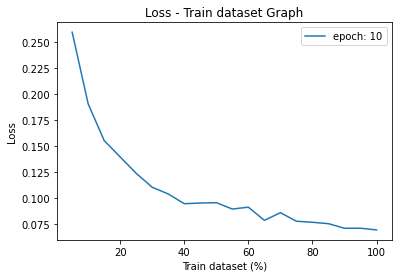

In [9]:
# Loss - Train dataset Graph

for each_epoch in epochs:
    plt.plot(*loss_graph_dict[each_epoch], label='epoch: {}'.format(each_epoch))
plt.xlabel('Train dataset (%)')
plt.ylabel('Loss')
plt.title('Loss - Train dataset Graph')
plt.legend()
plt.show()


## Accuracy - Train dataset Graph

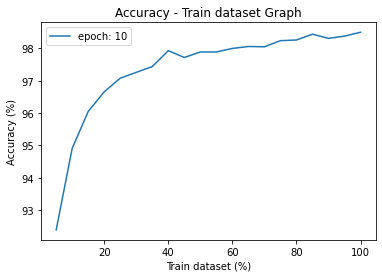

In [10]:
# Accuracy - Train dataset Graph

for each_epoch in epochs:
    plt.plot(*accuracy_graph_dict[each_epoch], label='epoch: {}'.format(each_epoch))
plt.xlabel('Train dataset (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy - Train dataset Graph')
plt.legend()
plt.show()


When loss value is lower and accuracy value is higher, we think that the performance of model is greater. \
Thus, the thing we can see in these graphs is when using more train data set, we can get greater performance of model. \
When using different optimizers (ex. Adagrad, Adam, ...), output will be different.